# Класификација на АДХД(?) преку ЕЕГ сигнали (предпроцесирање)

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import os
import seaborn as sns
from glob import glob
import warnings
from autopreprocess_pipeline import *
from autopreprocessing import dataset as ds
import shutil 
from tqdm import tqdm

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv1D, MaxPool1D, Dense, Flatten, Dropout

### Вчитување, филтрирање на пациенти од интерес и отстранување артефакти (?)

In [2]:
main_path = '/home/lukar/projects/eeg/data'

In [3]:
df = pd.read_csv(os.path.join(main_path, 'TDBRAIN_ID_and_status.csv')) # convert the .xlsx file into a .csv file beforehand
df_subset = df[['participants_ID', 'formal_status']] # only participants' ID and their status are needed from all columns
df_filtered = df_subset[df_subset['formal_status'].isin(['HEALTHY', 'ADHD'])] # out of the 5+ statuses (classes), only healthy and adhd ones are needed

filtered_file_path = '/home/lukar/projects/eeg/data/dataTDBRAIN_ID_and_status.csv'
df_filtered.to_csv(filtered_file_path, index=False) # save the .csv file

In [4]:
df_filtered
df_filtered.head()

,participants_ID,formal_status
0,sub-87974617,HEALTHY
1,sub-87974621,HEALTHY
2,sub-87974665,HEALTHY
3,sub-87974709,HEALTHY
4,sub-87974841,HEALTHY


In [ ]:
text = 'Fp1,Fp2,F7,F3,Fz,F4,F8,FC3,FCz,FC4,T7,C3,Cz,C4,T8,CP3,CPz,CP4,P7,P3,Pz,P4,P8,O1,Oz,O2,VPVA,VNVB,HPHL,HNHR,Erbs,OrbOcc,Mass' # electrode names copied from one .csv eeg recordings file
channel_names = text.split(',')  # split electrode names with commas
channel_names = [f"{name}" for name in channel_names] # create a list of strings 
print(channel_names)

In [ ]:
sourcepath = folders_path
preprocpath = '/home/lukar/projects/eeg/data/processed_subjects'

In [ ]:
varargsin = {
    'sourcepath' : folders_path,
    'preprocpath' : preprocpath
}

In [ ]:
autopreprocess_standard(varargsin=varargsin)

### Поделба на пациенти и сегментирање на сигналите 

In [5]:
def chop_string_from_end(string, char, flip):
    
    index = string.rfind(char)
    if not flip:
        if index != -1:
            chopped_string = string[index:]
        else:
            chopped_string = string

        return chopped_string
    else:
        if index != -1:
            chopped_string = string[:index]
        else:
            chopped_string = string

        return chopped_string



In [6]:
def segment_csv(path_to_file, path_to_dir, window_length=5000, stride=500):

    df = pd.read_csv(path_to_file)
    
    df = df.drop(columns=['artifacts', 'VEOG', 'HEOG', 'Erbs', 'OrbOcc', 'Mass'], axis=1)
    i=0 
    for i in range(110):
        #while (df.iloc[i*STRIDE + WINDOW_LENGTH] is not None):
        sub_df = df.iloc[i*stride : i*stride + window_length]
        i+=1
        subject_name = chop_string_from_end(path_to_file,"/", flip=0)
        clean_name = chop_string_from_end(subject_name,"eeg_csv",flip=1)

        #print(clean_name)
        seg_path = path_to_dir + "/" + clean_name + "_seg_" + str(i) + ".csv"

        # print(f"saving segment {i} of the patient to {seg_path}, window that captures row {i*stride} to {i*stride + window_length}")
        
        
        sub_df.to_csv(seg_path)       
    

In [ ]:
path_to_dir = "/home/lukar/projects/eeg/data/processed_subjects"

In [7]:

def find_csv_files(directory):
    """
    Recursively searches for .csv files in the given directory and its subdirectories.
    Returns a list of paths to the found .csv files.
    """
    csv_files = []

    # Traverse through all the files and directories in the given directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file has a .csv extension
            if file.endswith(".csv"):
                # If found, append the path to the list of csv_files
                csv_files.append(os.path.join(root, file))
                
    return csv_files            


In [10]:
df_dict = df_filtered.set_index('participants_ID')['formal_status'].to_dict()

In [11]:
source_dir = '/home/lukar/projects/eeg/data/processed_subjects'
target_dir_adhd = '/home/lukar/projects/eeg/data/adhd'
target_dir_healthy = '/home/lukar/projects/eeg/data/healthy'

In [12]:

for subject in os.listdir(source_dir):
   
    # index = file.rfind("/")
    # subject_name = file[index+1:]
    # subject_index = subject_name.find("_")
    # subject_name = subject_name[:subject_index]
   

    if df_dict[subject] == "HEALTHY":
        shutil.move(os.path.join(source_dir, subject), target_dir_healthy)
    elif df_dict[subject] == "ADHD":
        shutil.move(os.path.join(source_dir, subject), target_dir_adhd)   
                          


In [13]:
adhd_dir = os.listdir(target_dir_adhd)
healthy_dir = os.listdir(target_dir_healthy)

In [14]:
adhd_dir = [os.path.join(target_dir_adhd,subject) for subject in adhd_dir]
healthy_dir = [os.path.join(target_dir_healthy,subject) for subject in healthy_dir]

In [15]:
training_path = '/home/lukar/projects/eeg/data/training'
validation_path = '/home/lukar/projects/eeg/data/validation'
testing_path = '/home/lukar/projects/eeg/data/testing'

In [16]:
for i in range (len(healthy_dir)): #healthy_dir is the smaller set, so we will balance by using its length
    if i<31: # alternate between healthy and adhd subject and add 31 samples of each into training data 
        shutil.move(healthy_dir[i], training_path)
        shutil.move(adhd_dir[i], training_path)
    elif i >= 31 and i < 39:  # alternate between healthy and adhd subject and add 8 samples of each into validation data 
        shutil.move(healthy_dir[i], validation_path)
        shutil.move(adhd_dir[i], validation_path)
    elif i>=39 and i < 47: # alternate between healthy and adhd subject and add 8 samples of each into testing data
        shutil.move(healthy_dir[i], testing_path)
        shutil.move(adhd_dir[i], testing_path)

In [17]:
training_csv_files = find_csv_files(training_path)
validation_csv_files = find_csv_files(validation_path)
testing_csv_files = find_csv_files(testing_path)

In [18]:
training_segmented_path =   "/home/lukar/projects/eeg/data/training_segmented"
validation_segmented_path =  "/home/lukar/projects/eeg/data/validation_segmented"
testing_segmented_path = "/home/lukar/projects/eeg/data/testing_segmented"

In [20]:
for training_file in tqdm(training_csv_files):
    segment_csv(path_to_file = training_file, path_to_dir = training_segmented_path)

100%|█████████████████████████████████████████████████████████████████████████████████| 124/124 [17:46<00:00,  8.60s/it]


In [21]:
for validation_file in tqdm(validation_csv_files):
    segment_csv(path_to_file = validation_file, path_to_dir = validation_segmented_path)
   

100%|███████████████████████████████████████████████████████████████████████████████████| 36/36 [05:06<00:00,  8.52s/it]


In [22]:
for testing_file in tqdm(testing_csv_files):
    segment_csv(path_to_file = testing_file, path_to_dir = testing_segmented_path) 

100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [04:48<00:00,  8.48s/it]


### Извлекување на карактеристики и поделба во множества за тренирање, тестирање и валидација

In [140]:
training_filepaths = [os.path.join(training_segmented_path,file) for file in os.listdir(training_segmented_path)]
validation_filepaths = [os.path.join(validation_segmented_path,file) for file in os.listdir(validation_segmented_path)]
testing_filepaths = [os.path.join(testing_segmented_path,file) for file in os.listdir(testing_segmented_path)]

X_train = []
X_val = []
X_test = [] 

y_train = []
y_val = []
y_test = [] 

In [141]:
import numpy as np
import pywt
from scipy.spatial.distance import pdist
from scipy.stats import entropy
from sklearn.neighbors import NearestNeighbors

def wavelet_entropy(segment, wavelet='db4', level=4):
    coeffs = pywt.wavedec(segment, wavelet, level=level)
    entropy_list = []
    for coeff in coeffs:
        coeff = np.abs(coeff)
        norm_coeff = coeff / np.sum(coeff)
        entropy_list.append(entropy(norm_coeff))
    return np.mean(entropy_list)


import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew, entropy
from scipy.signal import welch
from scipy.integrate import simpson
from sklearn.preprocessing import StandardScaler
from numpy import log2, mean, sqrt
from math import log10

def compute_bandpower(segment, fs, band):
    freqs, psd = welch(segment, fs)
    band_freqs = (freqs >= band[0]) & (freqs <= band[1])
    band_power = simpson(y=psd[band_freqs], x=freqs[band_freqs])
    return band_power, psd, freqs

def hjorth_params(segment):
    # Hjorth Activity
    activity = np.var(segment)
    
    # Hjorth Mobility
    derivative = np.diff(segment)
    mobility = np.std(derivative) / np.std(segment)
    
    # Hjorth Complexity
    second_derivative = np.diff(derivative)
    complexity = (np.std(second_derivative) / np.std(derivative)) / mobility
    
    return activity, mobility, complexity

def spectral_entropy(psd):
    psd_norm = psd / np.sum(psd)
    return entropy(psd_norm)

def shannon_entropy(segment):
    prob_dist, _ = np.histogram(segment, bins=256, density=True)
    prob_dist = prob_dist[prob_dist > 0]
    return -np.sum(prob_dist * np.log2(prob_dist))

def higuchi_fd(segment, k_max):
    L = []
    x = np.asarray(segment)
    N = len(x)

    for k in range(1, k_max):
        Lk = 0
        for m in range(k):
            Lmk = 0
            for i in range(1, int(np.floor((N - m) / k))):
                Lmk += np.abs(x[m + i * k] - x[m + (i - 1) * k])
            Lmk = Lmk * (N - 1) / (int(np.floor((N - m) / k)) * k)
            Lk += Lmk
        L.append(np.log(Lk / k))

    return np.polyfit(np.log(range(1, k_max)), L, 1)[0]

    
def katz_fd(segment):
    L = np.sum(np.sqrt(np.ediff1d(segment) ** 2 + 1))
    d = np.max(np.abs(segment - segment[0]))
    N = len(segment)
    return log10(L) / (log10(d) + log10(N))

def petrosian_fd(segment):
    n = len(segment)
    diff = np.diff(segment)
    N_delta = np.sum(diff[1:] * diff[:-1] < 0)
    return log10(n) / (log10(n) + log10(n / (n + 0.4 * N_delta)))


In [142]:

def extract_features(df, fs,eo):
    feature_list = []

    for column in df.columns:
        segment = df[column].values
        # Compute time-domain features
        mean_val = np.mean(segment)
        std_val = np.std(segment)
        rms_val = np.sqrt(np.mean(segment**2))
        kurtosis_val = kurtosis(segment)
        skewness_val = skew(segment)

        # Compute Hjorth parameters
        activity, mobility, complexity = hjorth_params(segment)

        # Compute Shannon's entropy
        shannon_entropy_val = shannon_entropy(segment)

        # Compute band powers and PSD entropy
        delta_power, _, _ = compute_bandpower(segment, fs, [0.5, 4])
        theta_power, psd_t, freqs = compute_bandpower(segment, fs, [4, 8])
        alpha_power, _, _ = compute_bandpower(segment, fs, [8, 13])
        beta_power, psd_b, _ = compute_bandpower(segment, fs, [13, 30])
        gamma_power, _, _ = compute_bandpower(segment, fs, [30, 100])

        
        
        # Compute spectral entropy for theta and beta bands
        spectral_entropy_theta = spectral_entropy(psd_t)
        spectral_entropy_beta = spectral_entropy(psd_b)

        # Compute wavelet entropy
        wavelet_entropy_val = wavelet_entropy(segment)
        
        # Compute theta to beta power ratio
        theta_beta_ratio = theta_power/beta_power

        # Combine all features
        features = [
            mean_val, std_val, rms_val, kurtosis_val, skewness_val,
            activity, mobility, complexity, shannon_entropy_val, spectral_entropy_theta, spectral_entropy_beta,
            delta_power, theta_power, alpha_power, beta_power, gamma_power, wavelet_entropy_val, theta_beta_ratio
        ]
        feature_list.append(features)

    feature_array = np.array(feature_list)

    # Normalize the features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feature_array)

    # Flatten the array to a single vector
    normalized_features = normalized_features.flatten()

    # Append the additional feature (eo)
    final_feature_vector = np.append(normalized_features, eo)
   
    return final_feature_vector



In [143]:
for csv in tqdm(training_filepaths): 

    
    index = csv.rfind("/")
    subject_name = csv[index+1:]
    subject_index = subject_name.find("_")
    subject_name = subject_name[:subject_index]
   

    if df_dict[subject_name] == "HEALTHY":
        y_train.append(1)
    elif df_dict[subject_name] == "ADHD":
         y_train.append(0)

    
    segment = pd.read_csv(csv)
    segment = segment.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'])
    
    eyes_open_status = 1 if "restEO" in csv else 0     
    feature_file = extract_features(df = segment,fs = 500, eo = eyes_open_status)
    

    
    X_train.append(feature_file)

print (f"Training data loaded! Training set: {len(X_train)}, labels: {len(y_train)}")

100%|█████████████████████████████████████████████████████████████████████████████| 13640/13640 [15:17<00:00, 14.86it/s]

Training data loaded! Training set: 13640, labels: 13640


In [144]:
for csv in tqdm(validation_filepaths): 
    
    index = csv.rfind("/")
    subject_name = csv[index+1:]
    subject_index = subject_name.find("_")
    subject_name = subject_name[:subject_index]
   

    if df_dict[subject_name] == "HEALTHY":
        y_val.append(1)
    elif df_dict[subject_name] == "ADHD":
         y_val.append(0)

    
    segment = pd.read_csv(csv)
    segment = segment.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'])
    
    eyes_open_status = 1 if "restEO" in csv else 0
    feature_file = extract_features(df = segment,fs = 500,eo = eyes_open_status)
        
    
        
    X_val.append(feature_file)

print (f"Validation data loaded! Validation set: {len(X_val)}, labels: {len(y_val)}")

100%|███████████████████████████████████████████████████████████████████████████████| 3960/3960 [04:23<00:00, 15.01it/s]

Validation data loaded! Validation set: 3960, labels: 3960


In [145]:
for csv in tqdm(testing_filepaths): 
    
    index = csv.rfind("/")
    subject_name = csv[index+1:]
    subject_index = subject_name.find("_")
    subject_name = subject_name[:subject_index]
   

    if df_dict[subject_name] == "HEALTHY":
        y_test.append(1)
    elif df_dict[subject_name] == "ADHD":
         y_test.append(0)

    
    segment = pd.read_csv(csv)
    segment = segment.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'])
    eyes_open_status = 1 if "restEO" in csv else 0
    feature_file = extract_features(df = segment, fs = 500, eo = eyes_open_status)
  
    X_test.append(feature_file)

print (f"Testing data loaded! Testing set: {len(X_test)}, labels: {len(y_test)}")

100%|███████████████████████████████████████████████████████████████████████████████| 3740/3740 [04:10<00:00, 14.90it/s]

Testing data loaded! Testing set: 3740, labels: 3740


In [153]:
np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("X_val.npy", X_val)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)
np.save("y_val.npy", y_val)

In [206]:
np.save("y_train.npy", y_train)

In [186]:
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
X_val = np.load("X_val.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")
y_val = np.load("y_val.npy")

In [193]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])

In [194]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score

In [198]:
estimators = [35, 50, 75, 100, 125, 150, 175, 200] 
accuracies = []
for n in tqdm(estimators):
    adaboost = AdaBoostClassifier(n_estimators = n, algorithm="SAMME")
    adaboost.fit(X_train,y_train)
    preds = adaboost.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, preds))



100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [09:28<00:00, 71.10s/it]


<Axes: >

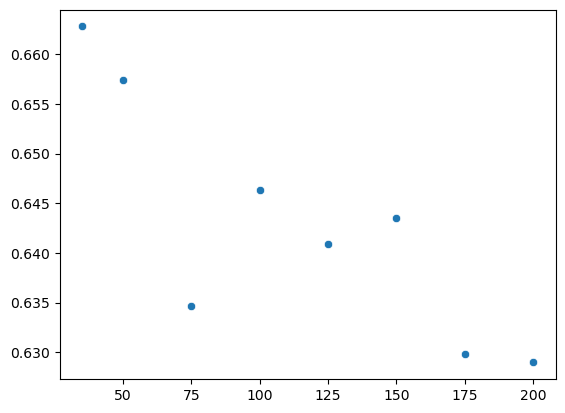

In [199]:
sns.scatterplot(x=estimators, y=accuracies)

In [200]:
estimators = [15, 20, 25, 30, 35, 40] 
accuracies = []
for n in tqdm(estimators):
    adaboost = AdaBoostClassifier(n_estimators = n, algorithm="SAMME")
    adaboost.fit(X_train,y_train)
    preds = adaboost.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, preds))


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:41<00:00, 16.95s/it]


<Axes: >

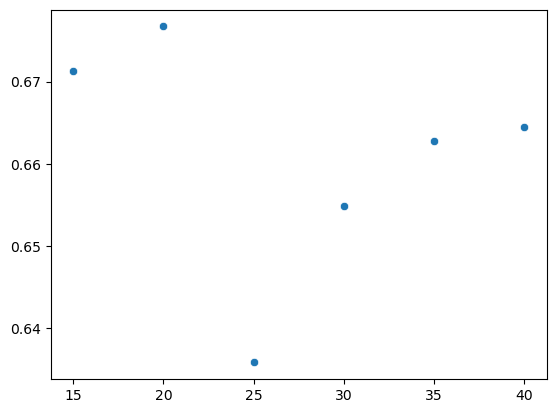

In [201]:
sns.scatterplot(x=estimators, y=accuracies)

In [202]:
adaboost = AdaBoostClassifier(n_estimators = 20, algorithm="SAMME")
adaboost.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME', n_estimators=20)

In [203]:
preds = adaboost.predict(X_test)

In [204]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.72      0.57      0.64      1760
           1       0.65      0.78      0.71      1760

    accuracy                           0.68      3520
   macro avg       0.68      0.68      0.67      3520
weighted avg       0.68      0.68      0.67      3520



In [161]:
important_feature_indices = np.where(adaboost.feature_importances_ > 0)[0]

print("Indices of important features:", important_feature_indices)

Indices of important features: [  6  30  38  39  43  50  60  68  69  78 104 105 114 122 132 133 145 150
 156 177 186 195 223 230 231 240 246 247 254 257 266 267 285 296 299 302
 321 356 357 366 372 374 375 383 385 393 402 407 411 423 426 427 428 429
 457 465]


In [162]:
X_train_selected = X_train_np[:, important_feature_indices]

In [163]:
X_test_selected = X_test_np[:,important_feature_indices]
X_val_selected = X_val_np[:, important_feature_indices]

In [164]:
from sklearn.svm import SVC

In [165]:
svm_classifier = SVC()
svm_classifier.fit(X_train_selected, y_train)

SVC()

In [166]:
y_pred = svm_classifier.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f'Classification Accuracy: {accuracy}')

Classification Accuracy: 0.40641711229946526


In [167]:
from sklearn.neural_network import MLPClassifier

In [168]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(8,16), max_iter=2000, random_state=42)
mlp_classifier.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred = mlp_classifier.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


In [ ]:
y_prob = mlp_classifier.predict_proba(X_test_selected)

In [169]:
print(accuracy)
print(report)

0.5315508021390374
              precision    recall  f1-score   support

           0       0.57      0.44      0.50      1980
           1       0.50      0.63      0.56      1760

    accuracy                           0.53      3740
   macro avg       0.54      0.54      0.53      3740
weighted avg       0.54      0.53      0.53      3740



In [177]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(16,32), max_iter=2000, random_state=42)
mlp_classifier.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred = mlp_classifier.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


In [178]:
print(report)
print(accuracy)

              precision    recall  f1-score   support

           0       0.47      0.46      0.47      1980
           1       0.41      0.43      0.42      1760

    accuracy                           0.44      3740
   macro avg       0.44      0.44      0.44      3740
weighted avg       0.45      0.44      0.44      3740

0.4443850267379679


In [179]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_np.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


2024-06-16 18:39:37.950164: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-16 18:39:38.146170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-16 18:39:38.146225: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-16 18:39:38.152984: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-16 18:39:38.153030: I external/local_xla/xla/stream_executor

In [180]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=8)

AttributeError: module 'tensorflow.python.distribute.input_lib' has no attribute 'DistributedDatasetInterface'

### Vote classification of whole readings 

In [ ]:
def get_majority_votes_on_test_set(arr):
    
    # Ensure the array length is divisible
    by 110
    if len(arr) % 110 != 0:
        raise ValueError("Array length must be divisible by 110")

    # Calculate the size of the new array
    new_size = len(arr) // 110
    new_arr = []

    # Loop through the original array in chunks of 110 elements
    for i in range(new_size):
        chunk = arr[i*110:(i+1)*110]
        # Count the number of 1s and 0s in the chunk
        count_1s = sum(chunk)
        count_0s = 110 - count_1s  # Since the chunk size is always 110

        # Append 1 if there are more 1s, otherwise append 0
        if count_1s > count_0s:
            new_arr.append(1)
        else:
            new_arr.append(0)

    return new_arr


In [ ]:
def get_true_classes(testing_dir):
    y_true = []
    test_subject_recordings = find_csv_files(testing_dir)
    for csv in test_subject_recordings: 
        index = csv.rfind("/")
        subject_name = csv[index+1:]
        subject_index = subject_name.find("_")
        subject_name = subject_name[:subject_index]
        if df_dict[subject_name] == "HEALTHY":
            y_true.append(1)
        elif df_dict[subject_name] == "ADHD":
             y_true.append(0)
    return y_true    

In [ ]:
y_true = get_true_classes(testing_path)

In [ ]:
adaboost = AdaBoostClassifier(n_estimators = 60, algorithm="SAMME")
adaboost.fit(X_train_selected,y_train)

In [ ]:
predictions = adaboost.predict(X_test_selected)

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
print(adaboost.feature_importances_)

In [ ]:
top_25_indices = np.argsort(adaboost.feature_importances_)[-25:][::-1]

print(top_25_indices)

In [ ]:
X_train_selected_2 = X_train_selected[:, top_25_indices]
X_test_selected_2 = X_test_selected[:,top_25_indices]
X_val_selected_2 = X_val_selected[:, top_25_indices]

In [ ]:
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train_selected_2, y_train)
y_pred = svm_classifier.predict(X_test_selected_2)
accuracy = accuracy_score(y_test, y_pred)
print(f'Classification Accuracy: {accuracy}')

In [ ]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(), max_iter=2000, random_state=42)
mlp_classifier.fit(X_train_selected_2, y_train)

# Predict and evaluate
y_pred = mlp_classifier.predict(X_test_selected_2)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [ ]:
print(accuracy)
print(report)

In [ ]:
print(len(important_feature_indices))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(
    n_estimators = 100,
    min_samples_split=20,
    min_samples_leaf=20
)

In [ ]:
rf.fit(X_train_selected,y_train)

In [ ]:
predictions_rf = rf.predict(X_test_selected)
print(classification_report(y_test,predictions_rf))

# Спектрограми

In [ ]:
from scipy import signal

In [ ]:
training_filepaths = [os.path.join(training_segmented_path,file) for file in os.listdir(training_segmented_path)]
validation_filepaths = [os.path.join(validation_segmented_path,file) for file in os.listdir(validation_segmented_path)]
testing_filepaths = [os.path.join(testing_segmented_path,file) for file in os.listdir(testing_segmented_path)]

In [ ]:
X_train_spectrograms = []
X_test_spectrograms = [] 
X_val_spectrograms = [] 
y_train_spectrograms = []
y_test_spectrograms = [] 
y_val_spectrograms = [] 

In [ ]:
fs = 500  # Sampling frequency
nperseg = 256  # Length of each segment
noverlap = 128  # Overlap between segments

def generate_spectrograms(training_filepaths, y_train_spectrograms):
    spectrogram_list = []
    for filepath in tqdm(training_filepaths):
        # Load the EEG data from CSV file
        eeg_data = pd.read_csv(filepath)
        
        index = filepath.rfind("/")
        subject_name = filepath[index+1:]
        subject_index = subject_name.find("_")
        subject_name = subject_name[:subject_index]
   

        if df_dict[subject_name] == "HEALTHY":
            y_train_spectrograms.append(1)
        elif df_dict[subject_name] == "ADHD":
             y_train_spectrograms.append(0)
        # Extract the data for each channel
        channels_data = {}
        for channel_name in eeg_data.columns:
            channels_data[channel_name] = eeg_data[channel_name].values

        # Create spectrogram for each channel
        spectrograms = {}
        for channel_name, channel_values in channels_data.items():
            f, t, Sxx = signal.spectrogram(channel_values, fs=fs, nperseg=nperseg, noverlap=noverlap)
            spectrograms[channel_name] = Sxx.T  # Transpose the spectrogram matrix

        spectrogram_list.append(spectrograms)

    return spectrogram_list, y_train

In [ ]:

X_train_spectrograms, y_train_spectrograms = generate_spectrograms(training_filepaths,y_train_spectrograms)

In [ ]:
X_test_spectrograms, y_test_spectrograms = generate_spectrograms(testing_filepaths, y_test_spectrograms)

In [ ]:
X_val_spectrograms, y_val_spectrograms = generate_spectrograms(validation_filepaths, y_val_spectrograms)